In [1]:
import pandas as pd
import numpy as np
import datasets
import torch
import os
from datasets import load_dataset, load_from_disk, concatenate_datasets
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification
from transformers import Trainer
from sklearn.model_selection import train_test_split
import evaluate

In [2]:
dataset = load_dataset('../data/ReviewPrediction', data_files={'train': 'train_binary.csv', 'test': 'test_binary.csv', 'validation': 'validation_binary.csv'})
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 6826
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 1897
    })
    validation: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', '_id', 'review', 'score', 'upvotes', 'downvotes', 'sum'],
        num_rows: 759
    })
})

In [3]:
checkpoint = 'bert-base-german-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['review'], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset["train"][0]

{'Unnamed: 0.1': 1893,
 'Unnamed: 0': 1893,
 '_id': '5c34e1c593ac7c001ca22f47',
 'review': 'Sehr gute Vorlesung - sehr unfaire Prüfung....',
 'score': 3,
 'upvotes': 11.0,
 'downvotes': 2.0,
 'sum': 1,
 'input_ids': [3,
  19386,
  4493,
  15428,
  27,
  26935,
  1120,
  174,
  8716,
  942,
  4185,
  26914,
  26914,
  26914,
  26914,
  4],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [4]:
tokenized_dataset = tokenized_dataset.remove_columns(["upvotes", "downvotes", "score", "Unnamed: 0", '_id', 'review'])
tokenized_dataset = tokenized_dataset.rename_column("sum", "labels")
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6826
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1897
    })
    validation: Dataset({
        features: ['Unnamed: 0.1', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 759
    })
})

In [5]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
torch.cuda.is_available()

True

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Hyperparameter optimization

In [37]:
from sklearn.metrics import classification_report, accuracy_score
from torch import nn
import optuna
from transformers import EarlyStoppingCallback

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    results = {}
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    print("############      Accuracy       ##############")
    print(acc)
    results.update({'accuracy':acc})
    return results

class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.35, 0.65], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def objective(trial: optuna.Trial):
    model,
    training_args = TrainingArguments(
        output_dir='./hp_optimization',
        learning_rate=trial.suggest_float('learning_rate', low=1e-6, high=0.01),
        #weight_decay=trial.suggest_float('weight_decay', 4e-5, 0.01),
        num_train_epochs=3,
        auto_find_batch_size=True,
        #per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [2, 4, 8, 16]),
        #per_device_eval_batch_size=trial.suggest_categorical("per_device_eval_batch_size", [2, 4, 8, 16]),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        #load_best_model_at_end=True,
        #per_device_train_batch_size=8,
        #per_device_eval_batch_size=8,
        disable_tqdm=True,
        )

    trainer = CustomLossTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['validation'],
        data_collator=data_collator,
        tokenizer=tokenizer,
        #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        compute_metrics=compute_metrics,
    )

    result = trainer.train()
    return result.training_loss

In [ ]:
#----------------------------------------------------------------------------------------------------
#                    CREATE OPTUNA STUDY
#----------------------------------------------------------------------------------------------------

print('Triggering Optuna study')
study = optuna.create_study(study_name='hp-search-electra', direction='minimize')
study.optimize(func=objective, n_trials=20)

[I 2023-10-25 17:40:00,318] A new study created in memory with name: hp-search-electra


Triggering Optuna study


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
[W 2023-10-25 17:40:01,971] Trial 0 failed with parameters: {'learning_rate': 0.008444808171735404} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\jorge\AppData\Local\Temp\ipykernel_4180\1227325410.py", line 58, in objective
    result = trainer.train()
  File "C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\transformers\trainer.py", line 1556, in train
    return inner_training_loop(
  File "C:\Users\jorge\anaconda3\envs\pytorch2\lib\site-packages\accelerate\utils\memory.py", line 136, in decorator
    return function(batch_size, *args, **kwargs)
  

## Weighted loss

In [7]:
from sklearn.metrics import classification_report, accuracy_score
from torch import nn


class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.35, 0.65], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
def compute_metrics(eval_preds):
    results = {}
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    class_report= classification_report(y_pred=predictions, y_true=labels)
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    print("############ Classification report ############")
    print(class_report)
    print("############      Accuracy       ##############")
    print(acc)
    results.update({'classification report' : class_report})
    results.update({'accuracy':acc})
    return results

training_args = TrainingArguments(
    'test-trainer', 
    auto_find_batch_size=True,
    #gradient_accumulation_steps=4,
    evaluation_strategy="epoch", 
    num_train_epochs=2,
    #per_device_train_batch_size=4,  
    #per_device_eval_batch_size=1,
    #eval_accumulation_steps=1,
    learning_rate=1e-5,
    #save_strategy="epoch",
    #load_best_model_at_end=True
)

trainer = CustomLossTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [8]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Classification report,Accuracy
1,0.777400,0.762289,precision recall f1-score support 0 0.70 0.85 0.77 499 1 0.50 0.30 0.38 260 accuracy 0.66 759 macro avg 0.60 0.57 0.57 759 weighted avg 0.63 0.66 0.63 759,0.658762
2,0.877800,1.357983,precision recall f1-score support 0 0.69 0.87 0.77 499 1 0.50 0.24 0.33 260 accuracy 0.66 759 macro avg 0.59 0.56 0.55 759 weighted avg 0.62 0.66 0.62 759,0.656126


############ Classification report ############
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       499
           1       0.50      0.30      0.38       260

    accuracy                           0.66       759
   macro avg       0.60      0.57      0.57       759
weighted avg       0.63      0.66      0.63       759

############      Accuracy       ##############
0.6587615283267457
############ Classification report ############
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       499
           1       0.50      0.24      0.33       260

    accuracy                           0.66       759
   macro avg       0.59      0.56      0.55       759
weighted avg       0.62      0.66      0.62       759

############      Accuracy       ##############
0.6561264822134387


TrainOutput(global_step=6826, training_loss=0.8068541139233263, metrics={'train_runtime': 875.0658, 'train_samples_per_second': 15.601, 'train_steps_per_second': 7.801, 'total_flos': 477839482083000.0, 'train_loss': 0.8068541139233263, 'epoch': 2.0})

In [9]:
predictions = trainer.predict(tokenized_dataset["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)

############ Classification report ############
              precision    recall  f1-score   support

           0       0.68      0.87      0.76      1247
           1       0.46      0.22      0.30       650

    accuracy                           0.65      1897
   macro avg       0.57      0.54      0.53      1897
weighted avg       0.61      0.65      0.61      1897

############      Accuracy       ##############
0.6457564575645757
(1897, 2) (1897,)


In [ ]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

print(accuracy_metric.compute(predictions=preds, references=predictions.label_ids))
print(precision_metric.compute(predictions=preds, references=predictions.label_ids, average='macro'))
print(recall_metric.compute(predictions=preds, references=predictions.label_ids, average='macro'))
print(f1_metric.compute(predictions=preds, references=predictions.label_ids, average='macro'))

In [27]:
preds

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

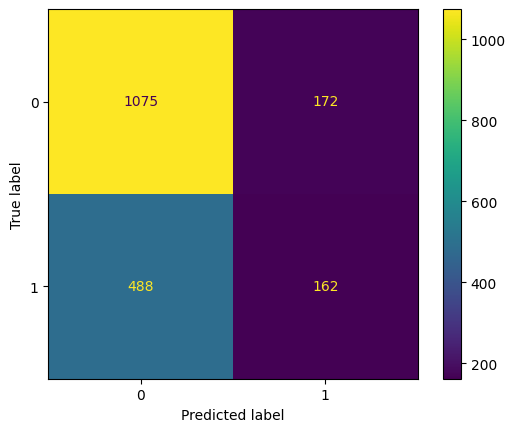

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(predictions.label_ids, preds)
ConfusionMatrixDisplay(cm).plot()

In [30]:
model.save_pretrained('../models/ReviewPrediction/model_binary_65val_65test')
tokenizer.save_pretrained('../models/ReviewPrediction/tokenizer_binary_65val_65test')

('../models/ReviewPrediction/tokenizer_binary_65val_65test\\tokenizer_config.json',
 '../models/ReviewPrediction/tokenizer_binary_65val_65test\\special_tokens_map.json',
 '../models/ReviewPrediction/tokenizer_binary_65val_65test\\vocab.txt',
 '../models/ReviewPrediction/tokenizer_binary_65val_65test\\added_tokens.json',
 '../models/ReviewPrediction/tokenizer_binary_65val_65test\\tokenizer.json')

## Load local model

In [20]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import evaluate
import torch

dataset = load_dataset('../data/ReviewPrediction', data_files={'test': 'test_binary.csv'})

tokenizer_local = AutoTokenizer.from_pretrained('../models/ReviewPrediction/tokenizer_binary_65val_65test')
model_local = AutoModelForSequenceClassification.from_pretrained('../models/ReviewPrediction/model_binary_65val_65test')

def tokenize_function(example):
    return tokenizer(example["review"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["upvotes", "downvotes", "score", "Unnamed: 0", "Unnamed: 0.1", '_id', 'review'])
tokenized_dataset = tokenized_dataset.rename_column("sum", "labels")
tokenized_dataset

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1897
    })
})

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_local.to(device)
device

device(type='cuda')

In [22]:
# Dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = torch.utils.data.DataLoader(tokenized_dataset["test"], batch_size=8, collate_fn=data_collator)

all_preds = []
all_labels = []

metric = evaluate.load("glue", "mrpc")
model_local.eval()
for batch in test_dataloader:
    batch = {k:v.to(model_local.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_local(**batch)
        
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())
    metric.add_batch(predictions=preds, references=batch["labels"])
    
metric.compute()

{'accuracy': 0.6520822351080654, 'f1': 0.32926829268292684}

In [18]:
all_preds

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,


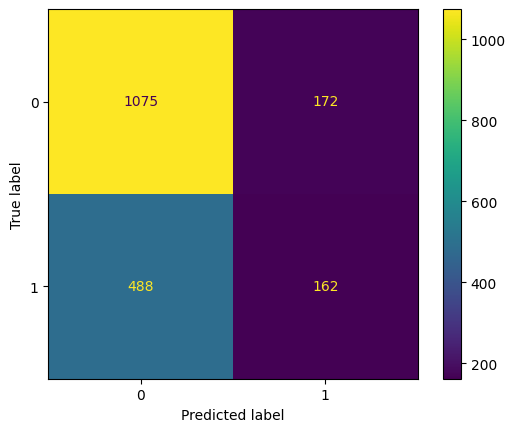

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()

In [24]:
from huggingface_hub import login
login()

In [26]:
model_local.push_to_hub("jorgeortizv/reviewUsefulness-binaryClassification")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jorgeortizv/reviewUsefulness-binaryClassification/commit/bf11a1985b01896f50c6b8a0ffdd3c30bcd11329', commit_message='Upload BertForSequenceClassification', commit_description='', oid='bf11a1985b01896f50c6b8a0ffdd3c30bcd11329', pr_url=None, pr_revision=None, pr_num=None)

In [27]:
tokenizer_local.push_to_hub("jorgeortizv/reviewUsefulness-binaryClassification")

CommitInfo(commit_url='https://huggingface.co/jorgeortizv/reviewUsefulness-binaryClassification/commit/5c19da2be36c3f56164e1e8a1949109fed4b6acc', commit_message='Upload tokenizer', commit_description='', oid='5c19da2be36c3f56164e1e8a1949109fed4b6acc', pr_url=None, pr_revision=None, pr_num=None)